In [2]:
! pip install simpy

In [172]:
import random
import simpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [140]:
from tqdm import tqdm

In [163]:
import seaborn as sns

In [181]:
from scipy import stats
from scipy.stats import norm

## Модель банка с отказами

### В этом примере моделируется окно обслуживания банка и клиенты, прибывающие в случайное время. У каждого клиента есть ограниченное время в очереди (отказы). Обслуживание длится некоторое время.

### Задание (выполнять в отдельном .py и .ipynb файлах)

Реализовать дополнительно следующую логику:

1. Сделать модель ограниченной по времени, а не по количеству клиентов. Клиентов сделать с двумя разными типами задач (отношение $3:1$). Задача первого типа с параметром $time\_in\_bank=9.0$, второго - $time\_in\_bank=15.0$.
2. Количество окон обслуживания сделать параметром модели. Приоритетов и выталкивания в модели нет.
3. Ввести экономическую функцию: за каждого обслуженно клиента с задачей первого типа прибыль $3$, второго типа - $6$, за потерянного клиента первого типа издержки $1.1$, второго типа - $2.5$, фиксированные издержки за сотрудников составляют $0.03$ в единицу времени на человека, а также бонус за задачу первого типа $0.3$, второго типа - $0.5$.

Максимизировать чистую прибыль по параметру числа окон на горизонте 5000 временых шагов.

### Инициализация стартовой модели

In [27]:
RANDOM_SEED = 42
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience
TIB1 = 9.0 # время в банке для задачи 1
TIB2 = 15.0 # время в банке для задачи 2
SIM_TIME = 5000 # время симуляции

In [130]:
def source(env, interval, counter):
    """Source generates customers randomly"""
    i = 0
    while True: 
        
        if random.uniform(0, 4.0) > 1.0: # определение типа задачи для пришедшего клиента
          time_in_bank = TIB1
          
        else:
          time_in_bank = TIB2
                
        c = customer(env, 'Customer%02d' % i, counter, time_in_bank, profit, loss)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)
        i += 1
        

def customer(env, name, counter, time_in_bank, profit, loss):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)
        profit, loss = profit, loss
        wait = env.now - arrive
        print(name, 'TIB', time_in_bank)
        if req in results:
            # We got to the counter
            if time_in_bank == TIB1:
              profit = 3 # прибыль за клиента типа 1
              loss = 0.3 # бонус сотруднику за клиента типа 1
            else:
              profit = 6 # прибыль за клиента типа 2
              loss = 0.5 # бонус сотруднику за клиента типа 2

            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            print('%7.4f %s: Finished' % (env.now, name))

        else:
            # We reneged
            if time_in_bank == TIB1:
              profit = - 1.1 # потеря клиента типа 1
              loss = 0
            else:
              profit = - 2.5 # потеря клиента типа 2
              loss = 0
            print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))
        profits.append(profit) # добавление прибыли (или убытка в случае потери) в массив 
        losses.append(loss) # добавление бонуса сотруднику в массив 
        print(name, 'profit', profit, 'loss', loss)

Оценим прибыль для количества окон 1-6 при фиксированном seed, чтобы выбрать диапазон количества окон для дальнейшего рассмотрения.

In [134]:
profit_for_p = []
for p in range(1, 7):
  profits = []
  losses = []
  # Setup and start the simulation
  print('Bank renege')
  random.seed(RANDOM_SEED)
  env = simpy.Environment()

  # Start processes and run
  counter = simpy.Resource(env, capacity=p) # количество окон - параметр 
  env.process(source(env, INTERVAL_CUSTOMERS, counter))
  env.run(until=SIM_TIME) # замена количества клиентов на время симуляции

  total_profit = np.array(profits).sum() - np.array(losses).sum() - SIM_TIME*p*0.03
  profit_for_p.append(total_profit)


Выходные данные были обрезаны до нескольких последних строк (5000).
Customer04 TIB 15.0
14.0644 Customer04: Waited  0.000
14.1622 Customer04: Finished
Customer04 profit 6 loss 0.5
17.8803 Customer02: Finished
Customer02 profit 3 loss 0.3
22.9625 Customer05: Here I am
Customer05 TIB 9.0
22.9625 Customer05: Waited  0.000
23.6575 Customer03: Finished
Customer03 profit 6 loss 0.5
24.4834 Customer05: Finished
Customer05 profit 3 loss 0.3
34.9404 Customer06: Here I am
Customer06 TIB 9.0
34.9404 Customer06: Waited  0.000
35.8559 Customer06: Finished
Customer06 profit 3 loss 0.3
39.0441 Customer07: Here I am
Customer07 TIB 9.0
39.0441 Customer07: Waited  0.000
48.3006 Customer08: Here I am
Customer08 TIB 9.0
48.3006 Customer08: Waited  0.000
50.8192 Customer07: Finished
Customer07 profit 3 loss 0.3
55.5281 Customer08: Finished
Customer08 profit 3 loss 0.3
84.4628 Customer09: Here I am
Customer09 TIB 9.0
84.4628 Customer09: Waited  0.000
92.2137 Customer09: Finished
Customer09 profit 3 loss 0.3

In [138]:
for i in range (1,7):
  print('Прибыль при количестве окон', i, 'равна', round(profit_for_p[i-1], ndigits = 1))

Прибыль при количестве окон 1 равна 434.2
Прибыль при количестве окон 2 равна 917.0
Прибыль при количестве окон 3 равна 1053.2
Прибыль при количестве окон 4 равна 1054.4
Прибыль при количестве окон 5 равна 944.3
Прибыль при количестве окон 6 равна 794.3


Далее рассмотрим прибыль при количестве окон 2, 3, 4, 5 и 1000 симуляций. (модель такая же, просто закомментила print)

In [139]:
def source(env, interval, counter):
    """Source generates customers randomly"""
    i = 0
    while True: 
        
        if random.uniform(0, 4.0) > 1.0: # определение типа задачи для пришедшего клиента
          time_in_bank = TIB1
          
        else:
          time_in_bank = TIB2
                
        c = customer(env, 'Customer%02d' % i, counter, time_in_bank, profit, loss)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)
        i += 1
        

def customer(env, name, counter, time_in_bank, profit, loss):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    #print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)
        profit, loss = profit, loss
        wait = env.now - arrive
        #print(name, 'TIB', time_in_bank)
        if req in results:
            # We got to the counter
            if time_in_bank == TIB1:
              profit = 3 # прибыль за клиента типа 1
              loss = 0.3 # бонус сотруднику за клиента типа 1
            else:
              profit = 6 # прибыль за клиента типа 2
              loss = 0.5 # бонус сотруднику за клиента типа 2

            #print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            #print('%7.4f %s: Finished' % (env.now, name))

        else:
            # We reneged
            if time_in_bank == TIB1:
              profit = - 1.1 # потеря клиента типа 1
              loss = 0
            else:
              profit = - 2.5 # потеря клиента типа 2
              loss = 0
            #print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))
        profits.append(profit) # добавление прибыли (или убытка в случае потери) в массив 
        losses.append(loss) # добавление бонуса сотруднику в массив 
        #print(name, 'profit', profit, 'loss', loss)

In [141]:
profit_for_p = []
for p in range(2, 6):
  total_profits = []
  for i in tqdm(range(1000)):   
      profits = []
      losses = []
      # Setup and start the simulation
      env = simpy.Environment()

      # Start processes and run
      counter = simpy.Resource(env, capacity=p)
      env.process(source(env, INTERVAL_CUSTOMERS, counter))
      env.run(until=SIM_TIME)
      total_profit = np.array(profits).sum() - np.array(losses).sum() - SIM_TIME*p*0.03
      total_profits.append(total_profit)
  profit_for_p.append(total_profits)


100%|██████████| 1000/1000 [00:28<00:00, 35.63it/s]


In [177]:
profit_for_p = np.array(profit_for_p)
mean_profit = profit_for_p.mean(axis=1)
std = profit_for_p.std(axis=1)
lower = mean_profit + norm.ppf(0.01)*std
upper = mean_profit + norm.ppf(0.99)*std

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

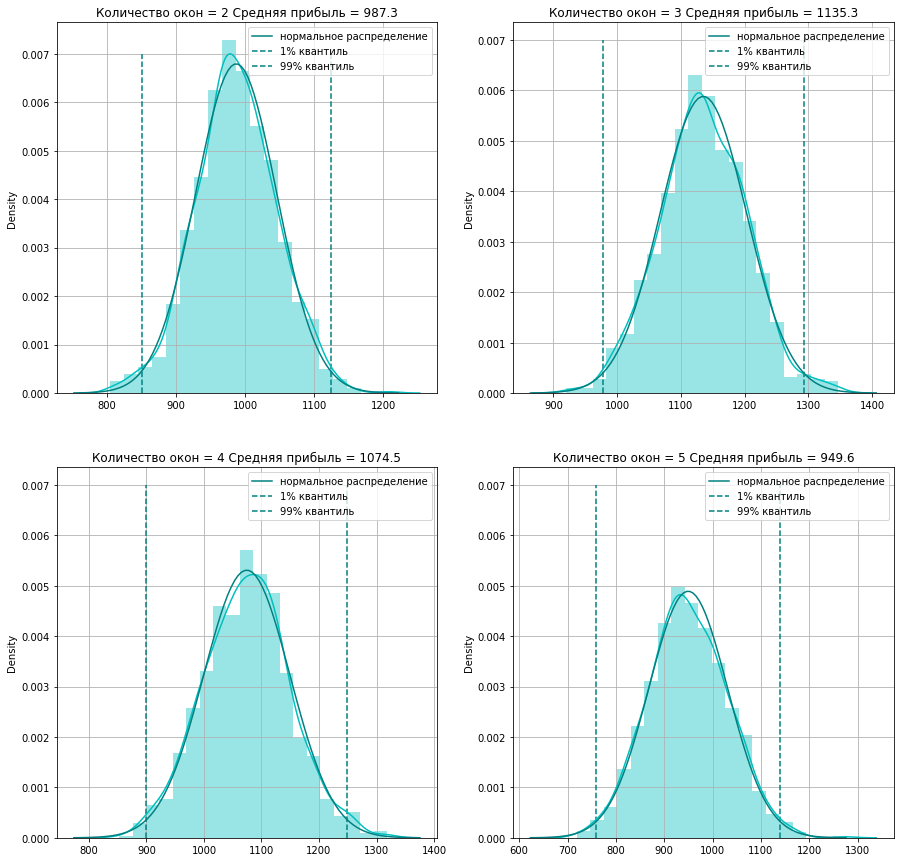

In [179]:
plt.figure(figsize=(15, 15))
for i in range(profit_for_p.shape[0]):
    plt.subplot(2,2,i+1)
    sns.distplot(profit_for_p[i], bins=20, color='c')
    n = i+2
    title = 'Количество окон = ' + str(n) + ' Средняя прибыль = ' + str(round(mean_profit[i], ndigits = 1))
    mu, sigma = mean_profit[i], std[i]
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    plt.plot(x, norm.pdf(x, mu, sigma), color= 'teal', label = 'нормальное распределение')
    plt.vlines(lower[i], ymin = 0, ymax = 0.007, color= 'teal', label = '1% квантиль', linestyle = 'dashed')
    plt.vlines(upper[i], ymin = 0, ymax = 0.007, color= 'teal', label = '99% квантиль', linestyle = 'dashed')
    plt.legend()
    plt.title(title)
    plt.grid()
plt.show()

Получены распределения, близкие к нормальным, по которым видно, что прибыль максимальна при использовании трех окон.

In [184]:
stats.ttest_ind(profit_for_p[1], profit_for_p[2], equal_var=False)

Ttest_indResult(statistic=18.999031790058815, pvalue=4.616732686696924e-74)

#### p-value = 0, следовательно средняя прибыль при использовании трех окон статистически значимо превышает прибыль при использовании четырех окон.